# 4 Mel Frequency Cepstrum Coefficients step-by-step

All tests OK


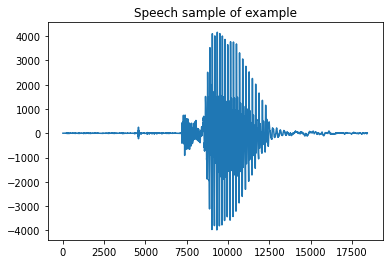

In [393]:
#Koray Amico Kulbay, DT2119, Lab1
import lab1_proto as proto
import numpy as np
import matplotlib.pyplot as plt
from test import tests
from sklearn.mixture import GaussianMixture
import pandas as pd
from plotnine import *
%matplotlib inline


tests()
example = np.load('lab1_example.npz', allow_pickle=True)['example'].item()
data = np.load('lab1_data.npz', allow_pickle=True)['data']

#Getting familiar with the set up
plt.plot(range(1,len(example["samples"])+1),example["samples"])
plt.title("Speech sample of example")
plt.show()



## 4.1 Enframe

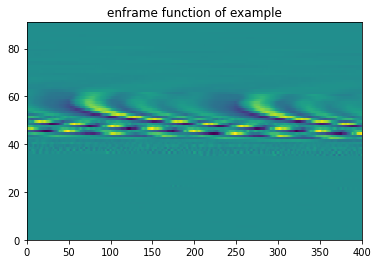

In [394]:
fsampling = 20E3 #Hz
winlen = int(20E-3*fsampling)
winshift = int(10E-3*fsampling)
examplesignal = example["samples"]
examplesignal = proto.enframe(examplesignal,winlen,winshift)
plt.pcolormesh(examplesignal)
plt.title("enframe function of example")
plt.show()

## 4.2 Pre-emphasis
Linear filter in general: $y[n] = \frac{1}{a_0}(\sum_{i=0}^Pb_ix[n-i] - \sum_{j=1}^Q a_jy[n-j])$

We want $y[n] = x[n] - \alpha x[n] $. 

Choose: P=1, Q=NaN, $b_0$=1, $b_1$=$- \alpha$ = -0.97, $a_0$=1

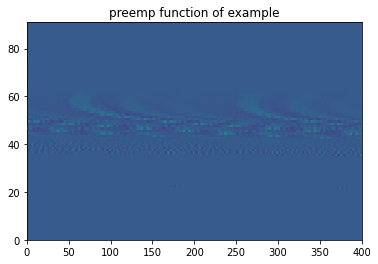

In [395]:
examplesignal = proto.preemp(examplesignal)
plt.pcolormesh(examplesignal)
plt.title("preemp function of example")
plt.show()

## 4.3 Hamming Window

This is needed to avoid sidelobes in fourier transform. Lose a bir of resolution, but better to lose that than having interference. 

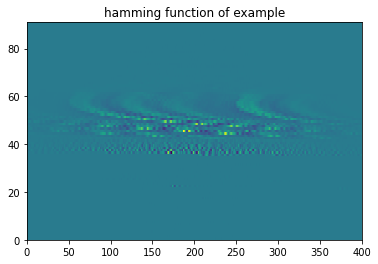

In [396]:
examplesignal = proto.windowing(examplesignal)
plt.pcolormesh(examplesignal)
plt.title("hamming function of example")
plt.show()

## 4.4 Fast Fourier Transform $\textcolor{red}{!!!}$

!! TODO: $f_{max} = ??$. Know that it's in the middle, ie at sample 512/2, but which frequency is that?

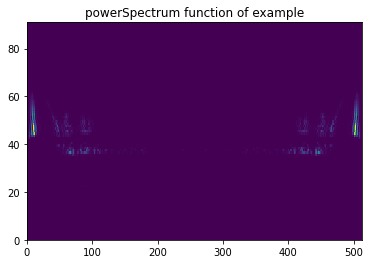

In [397]:
examplesignal = proto.powerSpectrum(examplesignal,512)
plt.pcolormesh(examplesignal)
plt.title("powerSpectrum function of example")
plt.show()

## 4.5 Mel filterbank log spectrum

The filter for the higher frequencies consists of "wider" triangles with larger relative spacing. This results in a lower resolution for high frequencies. This translated well into natural hearing of humans. 

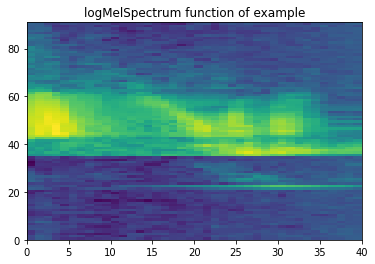

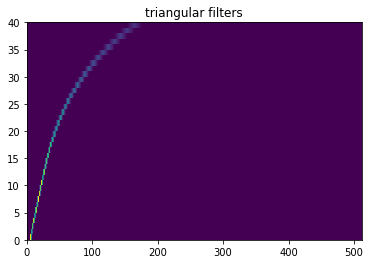

In [398]:
examplesignal,trfil = proto.logMelSpectrum(examplesignal,fsampling)
plt.pcolormesh(examplesignal)
plt.title("logMelSpectrum function of example")
plt.show()

plt.pcolormesh(trfil)
plt.title("triangular filters")
plt.show()

## 4.6 Cosine transform and Liftering

The expression for the coefficients is: 
$C_j = \sqrt{\frac{2}{N}} \sum_{i=1}^N A_i \cos(\frac{j \pi (i-0.5)}{N})$

We can see that each coefficient is affected by the size of N. This means that choosing a specific value for $N_p$ rather than truncating the desired coefficients from after using $N_q$, where $q>p$ $\Rightarrow \bar{C}_p \neq \bar{C}_q$. This can also be explained that when using different total number of coefficients a coeffiecent $C_i$ covers the amplitude of different "frequency spans".



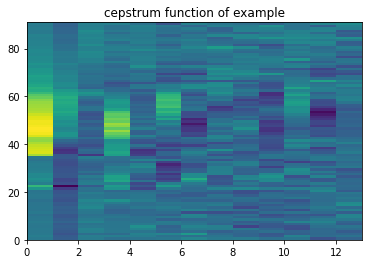

In [399]:
examplesignal = proto.cepstrum(examplesignal,13)
plt.pcolormesh(examplesignal)
plt.title("cepstrum function of example")
plt.show()

## Plotting coefficients of the main data


In [400]:
#plotting all speech samples
# for i in range(len(data)):
#     plt.pcolormesh(proto.mfcc(data[i]["samples"]))
#     plt.show()



# 5 Feature Correlation $\textcolor{red}{!!!}$


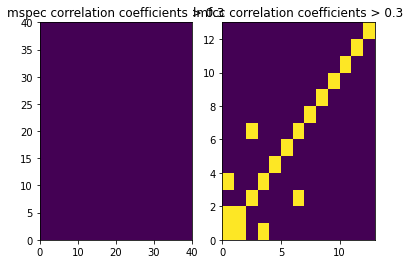

In [401]:
#Add processed information of each data point in data 

for i in range(len(data)):
    datapt = data[i]
    fsampling = datapt["samplingrate"]
    winlen = int(20E-3*fsampling)
    winshift = int(10E-3*fsampling)
    datapt["enframed"] = proto.enframe(datapt["samples"],winlen,winshift)
    datapt["preemp"] = proto.preemp(datapt["enframed"])
    datapt["windowing"] = proto.windowing(datapt["preemp"])
    datapt["powerSpectrum"] = proto.powerSpectrum(datapt["windowing"],512)
    datapt["mspec"] = proto.logMelSpectrum(datapt["powerSpectrum"],fsampling)[0]
    datapt["lmfcc"] = proto.cepstrum(datapt["mspec"],13)
    
# Create large concatinated Matrices for mpspec and lmfcc
Mmspec = np.concatenate([dp["mspec"] for dp in data])
Mlmfcc = np.concatenate([dp["lmfcc"] for dp in data])

# Create correleation coefficient matrix between all features for each feature type
corr_coef_mspec = np.corrcoef(Mmspec.T) #!! Transpose since np.corrcoef syntax has: each row is a variable; each column is a single observation. 
corr_coef_lmfcc = np.corrcoef(Mlmfcc.T)
fig, axs = plt.subplots(1,2)
axs[0].pcolormesh(corr_coef_mspec > 0.3) #sets all values < 0.3 = 0. #Pearson Corr coeff < 0.3 is regarded to be of small correlation: https://statistics.laerd.com/statistical-guides/pearson-correlation-coefficient-statistical-guide.php#:~:text=The%20Pearson%20product%2Dmoment%20correlation,and%20is%20denoted%20by%20r.
axs[0].set_title("mspec correlation coefficients > 0.3")
axs[1].pcolormesh(corr_coef_lmfcc > 0.3)
axs[1].set_title("lmfcc correlation coefficients > 0.3")

plt.show()

One can clearly see the stronger linear correlation for the liftered mfccs's on the right plot above compared to the uliftered ones to the left. Since the data shows a linear behaviour the assumption of a diagonal covariance matrix holds. $\textcolor{red}{!!!}$

# 6 Explore Speech Segments with Clustering

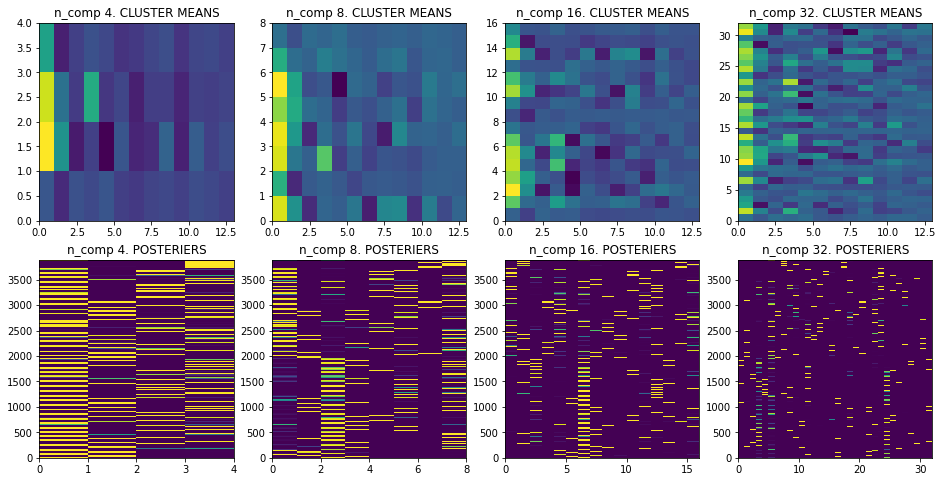

In [402]:
fig, axs = plt.subplots(2,4,figsize=(16, 8))
components_list = [4, 8, 16, 32]

for i, components in enumerate(components_list):
    GMM = GaussianMixture(n_components=components)
    gmm_plot_means = GMM.fit(Mlmfcc).means_
    gmm_plot_posts = GMM.fit(Mlmfcc).predict_proba(Mlmfcc)
    axs[0][i].pcolormesh(gmm_plot_means)
    axs[1][i].pcolormesh(gmm_plot_posts)
    axs[0][i].set_title("n_comp {}. CLUSTER MEANS".format(str(components)))
    axs[1][i].set_title("n_comp {}. POSTERIERS".format(str(components)))

plt.show()


#plot = GMM.fit(Mlmfcc).means_
#print(GMM.fit(Mlmfcc).means_)

#plt.pcolormesh(GMM.fit(Mlmfcc).means_)
#plt.show()


^^ ROW1: cluster id vs features (MFCC), colorplot is mean value for cluster location.

^^ROW2: observation instance (concatinated windows of all 44 samples) vs cluster id, colorplot is probability of observation to be assigned to cluster_col

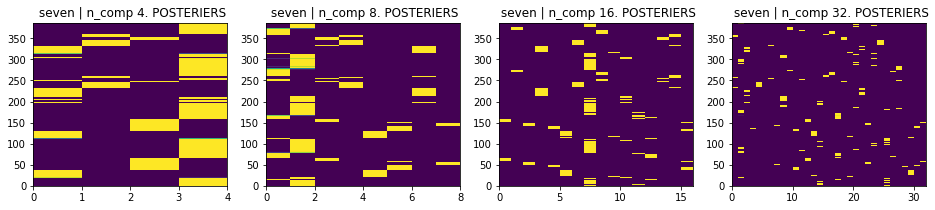

In [403]:
id_seven = [16, 17, 38, 39]

#check
Mlmfcc_7 = []
for id in id_seven:
    if data[id]["digit"] != "7": 
        raise Exception("not comparing all 7's!")
    Mlmfcc_7.append(data[id]["lmfcc"])
Mlmfcc_7 = np.concatenate(Mlmfcc_7)

fig, axs = plt.subplots(1,4,figsize=(16, 3))

for i, components in enumerate(components_list):
    GMM = GaussianMixture(n_components=components)
    gmm_plot_posts = GMM.fit(Mlmfcc_7).predict_proba(Mlmfcc_7)
    axs[i].pcolormesh(gmm_plot_posts)
    axs[i].set_title(" seven | n_comp {}. POSTERIERS".format(str(components)))

plt.show()


    


^^ concatinated windows for all 4 instances of "seven" vs cluster id. colorplot is probability of observation/window to be assigned to cluster_col

We now continue to compare the posterior plot of a man and woman

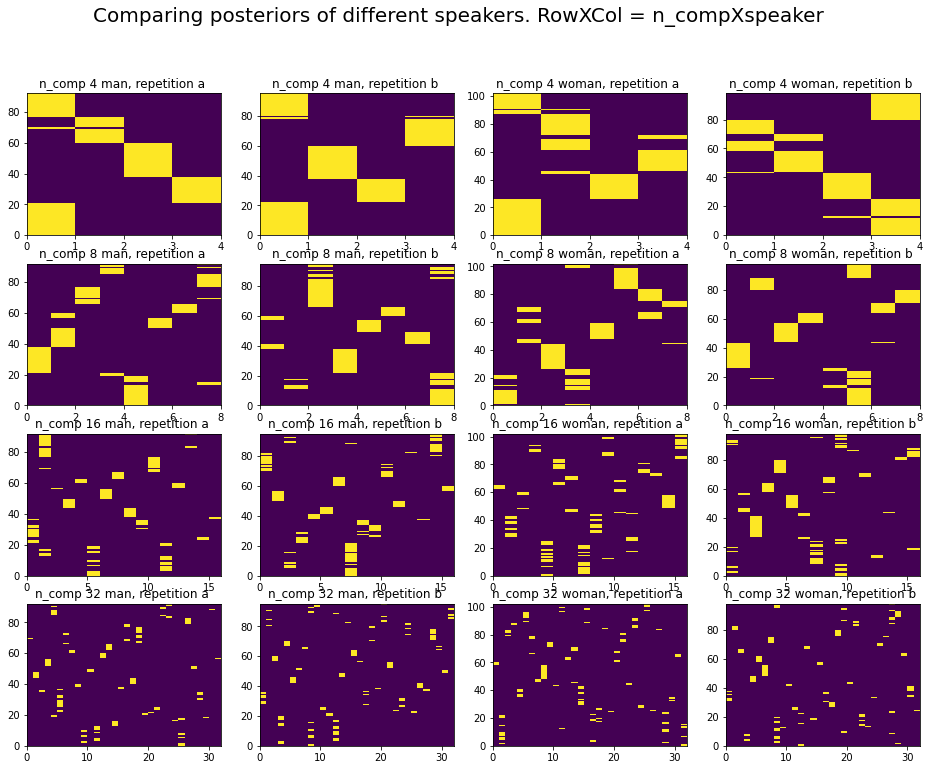

In [404]:

fig, axs = plt.subplots(4,4,figsize=(16, 12))
for j, speaker_id in enumerate(id_seven):
    speaker_data = data[speaker_id]
    Mlfcc_curr_speaker = speaker_data["lmfcc"]
    for i, components in enumerate(components_list):
        GMM = GaussianMixture(n_components=components)
        gmm_plot_posts = GMM.fit(Mlfcc_curr_speaker).predict_proba(Mlfcc_curr_speaker)
        axs[i][j].pcolormesh(gmm_plot_posts)
        axs[i][j].set_title("n_comp {} {}, repetition {} ".format(str(components),str(speaker_data["gender"]),str(speaker_data["repetition"])))

plt.suptitle('Comparing posteriors of different speakers. RowXCol = n_compXspeaker',fontsize=20)
plt.show()

**Can you say something about the classes discovered by the unsupervised learning method? Do the classes roughly correspond to the phonemes you expect to compose each word?**
Phonemes for the word seven would be |s|e|v|e|n|, looking at the clusters above they could certainly refer to this. 

**Are those classes a stable representation of the word if you compare utterances from different speakers.**
Comparing the cluster for 4 GMM components between the man and woman one can see that the clusters represents "different phonemes", this means that the cluster are not a stable representation.